# Scikit-image testbench for image classification

## First steps: import and show an image with scikit-image


In [464]:
%matplotlib inline


/home/gino/Desktop/fruits-360_dataset/fruits-360/Training/Banana/0_100.jpg


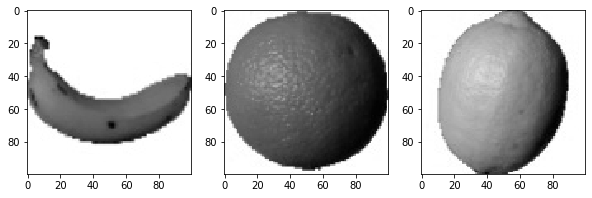

In [465]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

# path to fruit360 dataset
path = '/home/gino/Desktop/fruits-360_dataset/'

def img_grayscale(image):
    return io.imread(image, as_gray=True)

#banana_collection = io.ImageCollection([path + 'fruits-360/Training/Banana/*.jpg', path + 'fruits-360/Training/Banana Lady Finger/*.jpg'], load_func=img_grayscale)
banana_collection = io.ImageCollection(path + 'fruits-360/Training/Banana/*.jpg', load_func=img_grayscale)
orange_collection = io.ImageCollection(path + 'fruits-360/Training/Orange/*.jpg', load_func=img_grayscale)
lemon_collection = io.ImageCollection(path + 'fruits-360/Training/Lemon/*.jpg', load_func=img_grayscale)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

sample_banana = banana_collection[50]
ax0.imshow(sample_banana, cmap='gray')
ax1.imshow(orange_collection[0], cmap='gray')
ax2.imshow(lemon_collection[1], cmap='gray')

#a = io.imread(banana_collection.files[100], as_gray=True)
#io.imshow(a)

#print(a)

print(banana_collection.files[0])

## Filtering

In [466]:
from skimage import filters

### Gaussian filter

(100, 100)
float64


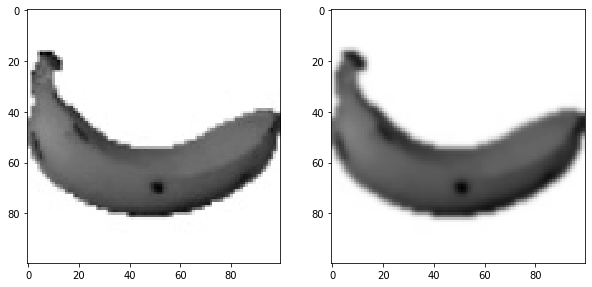

In [467]:

gauss_filtered = filters.gaussian(sample_banana, sigma=1)

print(gauss_filtered.shape)
print(sample_banana.dtype)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(sample_banana, cmap='gray')
ax[1].imshow(gauss_filtered, cmap='gray')

fig.set_size_inches(10, 10)

### Edge detection: Sobel and Scharr filters

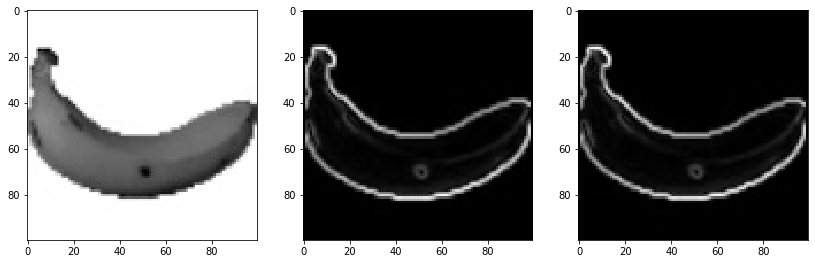

In [468]:
sobel_filtered = filters.sobel(sample_banana)

#plt.imshow(sample_banana, cmap='gray')

scharr_filtered = filters.scharr(sample_banana)

fig, ax = plt.subplots(1, 3)

ax[0].imshow(sample_banana, cmap='gray')
ax[1].imshow(sobel_filtered, cmap='gray')
ax[2].imshow(scharr_filtered, cmap='gray')

fig.set_size_inches(14, 14)

#plt.imshow(scharr_filtered - sobel_filtered, cmap='gray')

### More edge detection: Canny filter

The Canny filter is a multi-stage edge detector. It uses a filter based on the derivative of a Gaussian in order to compute the intensity of the gradients. The Gaussian reduces the effect of noise present in the image. Then, potential edges are thinned down to 1-pixel curves by removing non-maximum pixels of the gradient magnitude. Finally, edge pixels are kept or removed using hysteresis thresholding on the gradient magnitude.

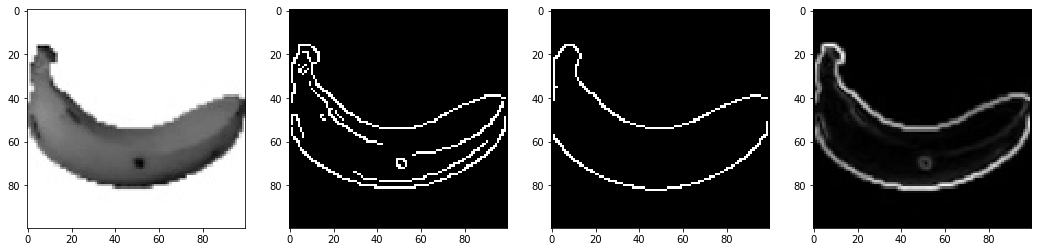

In [469]:
from skimage import feature
import matplotlib.pyplot as plt

canny_filtered_lowsigma = feature.canny(sample_banana, sigma=.5)
canny_filtered_hisigma = feature.canny(sample_banana, sigma=3)


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

ax[0].imshow(sample_banana, cmap='gray')
ax[1].imshow(canny_filtered_lowsigma, cmap='gray')
ax[2].imshow(canny_filtered_hisigma, cmap='gray')
#ax[3].imshow(canny_filtered_pregaussian, cmap='gray')
ax[3].imshow(sobel_filtered, cmap='gray')

### Thresholding

Many techniques exist but given the quality of the dataset we will not require any fancy thresholding algorithms or methods as hystheresis thresholing. The latter is used in the Canny edge-detection filter.  

0.7254720052083334


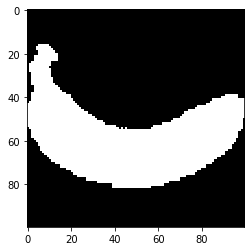

In [470]:
# Threshold value. Can be obtained algorithmically
threshold = .9

thresholded_banana = sample_banana < threshold
plt.imshow(thresholded_banana, cmap='gray')


threshold = filters.threshold_otsu(sample_banana)

thresholded_banana = sample_banana < threshold
plt.imshow(thresholded_banana, cmap='gray')

print(threshold)

### Trying all thresholding methods

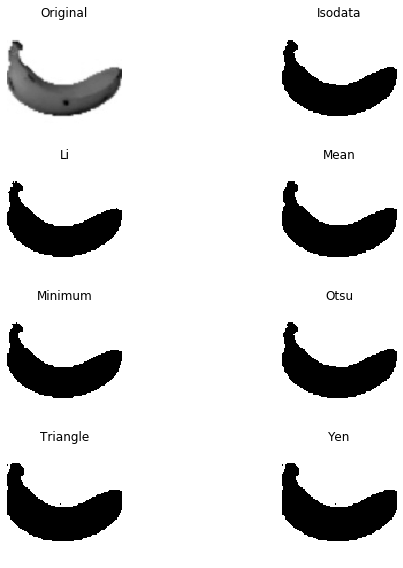

In [471]:
fig, ax = filters.try_all_threshold(filters.gaussian(sample_banana, sigma=.5), figsize=(10, 8), verbose=False)
plt.show()

## Feature extraction

### Moments and inertia tensor I

After preprocessing the images we need to find a feature which can be expressed as a number to identify each fruit. Since foreground has been separated from background we can find the moments of the resulting shape. This can be done with either the grayscale image or the binary one. Even though the grayscale version has informatino about the texture of the fruit we'll focus by now on binary images because these lack noise from lighting sources, from example, which can affect measurements. 

[[2.99600000e+03 1.35649000e+05 8.63014700e+06 6.26471809e+08]
 [1.72924000e+05 8.12308500e+06 5.08730089e+08 3.61091560e+10]
 [1.05038640e+07 5.02088947e+08 3.08941699e+10 2.14443780e+12]
 [6.61889008e+08 3.18968379e+10 1.92847326e+12 1.31007012e+14]]

Area: 2996.0

Centroid (row, column): (57.71829105473965, 45.276702269692926)


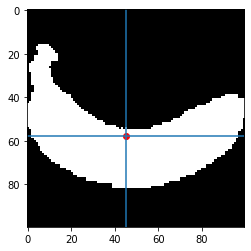

In [472]:
from skimage import measure

M = measure.moments(thresholded_banana)
print(M)
print("\nArea:", M[0, 0])

centroid = (M[1, 0] / M[0, 0], M[0, 1] / M[0, 0]) 
print("\nCentroid (row, column):", centroid)

fig, ax = plt.subplots(ncols=1, nrows=1)

ax.imshow(thresholded_banana, cmap='gray')
ax.axhline(centroid[0])
ax.axvline(centroid[1])

ax.scatter(x=centroid[1], y=centroid[0], color='r')


For some reason there is a discrepancy in the calculation of the central moments. If the centroid is previously provided and passed to the function the centroidal moment matrix are different and results of following calculations might be affected. 

This happened once but now seems to been solved

UPDATE: happened again, both array in the prints below were different. But re-running other cells solved it

Is this a bug? (or a feature)

In [473]:
# Moments

central_moments = measure.moments_central(thresholded_banana, center=centroid)
print("Centroidal moments (w/ centroid previously calculated):\n", central_moments)

central_moments = measure.moments_central(thresholded_banana)
print("Centroidal moments (centroid not used):\n", central_moments, "\n")

normalized_central_moments = measure.moments_normalized(central_moments)
print("\nNormalized centroidal moments:\n", normalized_central_moments)


Centroidal moments (w/ centroid previously calculated):
 [[ 2.99600000e+03 -6.62296884e-11  2.48840761e+06  1.03934314e+07]
 [-1.63566938e-11  2.93656537e+05 -1.59788466e+07  3.14712365e+08]
 [ 5.22986238e+05 -7.39008292e+06  5.15674548e+08 -9.98809611e+09]
 [-4.74781532e+06  2.73452051e+08 -1.11085782e+10  3.77505790e+11]]
Centroidal moments (centroid not used):
 [[ 2.99600000e+03 -6.62296884e-11  2.48840761e+06  1.03934314e+07]
 [-1.63566938e-11  2.93656537e+05 -1.59788466e+07  3.14712365e+08]
 [ 5.22986238e+05 -7.39008292e+06  5.15674548e+08 -9.98809611e+09]
 [-4.74781532e+06  2.73452051e+08 -1.11085782e+10  3.77505790e+11]] 


Normalized centroidal moments:
 [[        nan         nan  0.27722852  0.02115458]
 [        nan  0.03271569 -0.03252302  0.01170276]
 [ 0.05826485 -0.01504163  0.01917566 -0.00678557]
 [-0.00966361  0.01016847 -0.00754679  0.0046855 ]]


In [474]:
hu_moments = measure.moments_hu(normalized_central_moments)
print("Hu moments:\n", hu_moments)

hu_moments = [-1*np.sign(j)*np.log10(np.abs(j)) for j in hu_moments[:]]
print("Normalized Hu moments: \n", hu_moments)

inertia_tensor = measure.inertia_tensor(thresholded_banana, mu=central_moments)
print("Inertia Tensor:\n", inertia_tensor)


Hu moments:
 [ 3.35493369e-01  5.22263523e-02  1.21203368e-02  1.81708002e-03
 -8.33229482e-06 -4.15257477e-04  1.81383918e-06]
Normalized Hu moments: 
 [0.47431605871160304, 1.2821103063463055, 1.9164853130405455, 2.7406259469147276, -5.079235372092, -3.381682539279386, 5.7414012203424285]
Inertia Tensor:
 [[830.57664013 -98.01620051]
 [-98.01620051 174.56149454]]


The eigenvalues of the inertia tensor are the __principal moments of inertia__. The corresponding eigenvectors correspond to the __principal axis of inertia__.

In [475]:
inertia_eigvalues = measure.inertia_tensor_eigvals(thresholded_banana, T=inertia_tensor)
print(inertia_eigvalues)

[844.9082899929406, 160.22984467616033]


In [476]:
# Principal moments ratio

ratio = max(inertia_eigvalues)/min(inertia_eigvalues)

if len(inertia_eigvalues) == 2:
    print("Principal moments ratio: ", ratio)
else:
    print("Fail")


Principal moments ratio:  5.273101847540202


### Moments and inertia tensor II. Comparison between shape, contour and textured.

[[3.06000000e+02 1.31310000e+04 8.78283000e+05 6.74249070e+07]
 [1.65090000e+04 7.73018000e+05 5.15457320e+07 3.90022920e+09]
 [1.00306700e+06 4.85903480e+07 3.19519764e+09 2.37463495e+11]
 [6.57894330e+07 3.21836626e+09 2.07704020e+11 1.51276743e+13]]

Area: 306.0

Centroid (row, column): (53.950980392156865, 42.911764705882355)


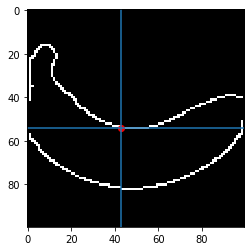

In [477]:
M = measure.moments(canny_filtered_hisigma)

print(M)
print("\nArea:", M[0, 0])

centroid = (M[1, 0] / M[0, 0], M[0, 1] / M[0, 0]) 
print("\nCentroid (row, column):", centroid)

fig, ax = plt.subplots(ncols=1, nrows=1)

ax.imshow(canny_filtered_hisigma, cmap='gray')
ax.axhline(centroid[0])
ax.axvline(centroid[1])

ax.scatter(x=centroid[1], y=centroid[0], color='r')


In [478]:
# Moments

print("\nCANNY THRESHOLDED IMAGE \n\n")

central_moments = measure.moments_central(thresholded_banana, center=centroid)

print("Centroidal moments:\n", central_moments)

normalized_central_moments = measure.moments_normalized(central_moments)

print("\nNormalized centroidal moments:\n", normalized_central_moments)

hu_moments = measure.moments_hu(normalized_central_moments)
print("Hu moments:\n", hu_moments)

inertia_tensor = measure.inertia_tensor(thresholded_banana, mu=central_moments)
print("Inertia Tensor:\n", inertia_tensor)

inertia_eigvalues = measure.inertia_tensor_eigvals(thresholded_banana, T=inertia_tensor)
print(inertia_eigvalues)

# Principal moments ratio

ratio = max(inertia_eigvalues)/min(inertia_eigvalues)

if len(inertia_eigvalues) == 2:
    print("Principal moments ratio: ", ratio)
else:
    print("Fail")



CANNY THRESHOLDED IMAGE 


Centroidal moments:
 [[ 2.99600000e+03  7.08535294e+03  2.50516403e+06  2.80878452e+07]
 [ 1.12868627e+04  3.20349262e+05 -5.15215664e+06  3.12088281e+08]
 [ 5.65507356e+05 -3.84010253e+06  4.09270989e+08 -4.49373429e+09]
 [ 1.32312984e+06  2.05562232e+08 -4.86287133e+09  2.40643767e+11]]

Normalized centroidal moments:
 [[        nan         nan  0.27909532  0.05716944]
 [        nan  0.03568947 -0.0104866   0.01160518]
 [ 0.06300204 -0.00781607  0.01521898 -0.00305289]
 [ 0.00269307  0.00764395 -0.00330367  0.00298681]]
Hu moments:
 [ 3.42097361e-01  5.17912559e-02  7.66562129e-03  2.49649392e-03
  1.08950839e-05  4.58315039e-04 -7.54489294e-07]
Inertia Tensor:
 [[ 836.16956981 -106.92565501]
 [-106.92565501  188.75412417]]
[853.372077857158, 171.55161612107463]
Principal moments ratio:  4.974433334716476


[[1.64583413e+03 7.65382554e+04 4.90772504e+06 3.57530259e+08]
 [9.59787940e+04 4.62792646e+06 2.92216490e+08 2.08173947e+10]
 [5.89862537e+06 2.89055375e+08 1.79369217e+10 1.24980740e+12]
 [3.76214696e+08 1.85618888e+10 1.13204806e+12 7.72135774e+13]]

Area: 1645.8341294117647

Centroid (row, column): (58.316201036750414, 46.504233953931184)


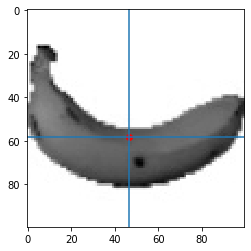

In [479]:
# Use negative image. White is 1 and black is 0
M = measure.moments( 1 - sample_banana)

print(M)
print("\nArea:", M[0, 0])

centroid = (M[1, 0] / M[0, 0], M[0, 1] / M[0, 0]) 
print("\nCentroid (row, column):", centroid)

fig, ax = plt.subplots(ncols=1, nrows=1)

ax.imshow(sample_banana, cmap='gray')
ax.axhline(centroid[0])
ax.axvline(centroid[1])

ax.scatter(x=centroid[1], y=centroid[0], color='r')


In [480]:
# Moments

print("\nGRAYSCALE IMAGE \n\n")

central_moments = measure.moments_central(thresholded_banana, center=centroid)

print("Centroidal moments:\n", central_moments)

normalized_central_moments = measure.moments_normalized(central_moments)

print("\nNormalized centroidal moments:\n", normalized_central_moments)

hu_moments = measure.moments_hu(normalized_central_moments)
print("Hu moments:\n", hu_moments)

hu_moments = [-1*np.sign(j)*np.log10(np.abs(j)) for j in hu_moments[:]]
print("Normalized Hu moments: \n", hu_moments)


inertia_tensor = measure.inertia_tensor(thresholded_banana, mu=central_moments)
print("Inertia Tensor:\n", inertia_tensor)

inertia_eigvalues = measure.inertia_tensor_eigvals(thresholded_banana, T=inertia_tensor)
print(inertia_eigvalues)

# Principal moments ratio

ratio = max(inertia_eigvalues)/min(inertia_eigvalues)

if len(inertia_eigvalues) == 2:
    print("Principal moments ratio: ", ratio)
else:
    print("Fail")



GRAYSCALE IMAGE 


Centroidal moments:
 [[ 2.99600000e+03 -3.67768493e+03  2.49292209e+06  1.22409220e+06]
 [-1.79133831e+03  2.95855461e+05 -1.81903350e+07  3.74151564e+08]
 [ 5.24057297e+05 -8.38454021e+06  5.55466878e+08 -1.23693464e+10]
 [-5.68655179e+06  2.94003230e+08 -1.27644560e+10  4.41444840e+11]]

Normalized centroidal moments:
 [[        nan         nan  0.27773147  0.00249149]
 [        nan  0.03296067 -0.03702424  0.01391304]
 [ 0.05838418 -0.01706572  0.02065536 -0.00840331]
 [-0.01157429  0.01093268 -0.00867173  0.0054791 ]]
Hu moments:
 [ 3.36115643e-01  5.24588559e-02  1.27824109e-02  2.57422583e-03
 -2.96127259e-06 -3.78084767e-04  1.44664842e-05]
Normalized Hu moments: 
 [0.4735112753586643, 1.280181185562368, 1.893387225987823, 2.5893533562469564, -5.528521613115511, -3.4224108193962923, 4.839637003336679]
Inertia Tensor:
 [[832.08347416 -98.75015395]
 [-98.75015395 174.91899089]]
[846.6016295301051, 160.40083552139214]
Principal moments ratio:  5.2780375287833


## Feature comparison

### Between bananas, oranges and lemons

We'll measure the principal moments ratio for all the fruit pictures in the respective training dataset.

In [481]:
banana_size = len(banana_collection)
orange_size = len(orange_collection)
lemon_size = len(lemon_collection)


threshold = 0.9

banana_hu_moments = np.zeros((banana_size, 7))
banana_moment_ratio = np.zeros((banana_size, 1))
banana_eigvalues = np.zeros((banana_size, 2))


for i, image in enumerate(banana_collection):
    
    current_fruit = banana_collection[i]
    
    thresholded_fruit = current_fruit < threshold
    #thresholded_fruit = current_fruit
    
    fruit_central_moments = measure.moments_central(thresholded_fruit)
    
    banana_hu_moments[i, :] = measure.moments_hu(measure.moments_normalized(fruit_central_moments))
    
    # Single line log transformation. I'm proud of this line
    banana_hu_moments[i, :] = [-1*np.sign(j)*np.log10(np.abs(j)) for j in banana_hu_moments[i, :]]

    banana_eigvalues[i, :] = measure.inertia_tensor_eigvals(thresholded_fruit, mu=fruit_central_moments)
    
    banana_moment_ratio[i, 0] = max(banana_eigvalues[i, :])/min(banana_eigvalues[i, :])
    

In [482]:
orange_hu_moments = np.zeros((orange_size, 7))
orange_moment_ratio = np.zeros((orange_size, 1))
orange_eigvalues = np.zeros((orange_size, 2))

for i, image in enumerate(orange_collection):
    
    current_fruit = orange_collection[i]
    
    thresholded_fruit = current_fruit < threshold
    #thresholded_fruit = current_fruit
    
    fruit_central_moments = measure.moments_central(thresholded_fruit)
    
    orange_hu_moments[i, :] = measure.moments_hu(measure.moments_normalized(fruit_central_moments))
    
    # log transformation
    orange_hu_moments[i, :] = [-1*np.sign(j)*np.log10(np.abs(j)) for j in orange_hu_moments[i, :]]

    orange_eigvalues[i, :] = measure.inertia_tensor_eigvals(thresholded_fruit, mu=fruit_central_moments)
    
    orange_moment_ratio[i, 0] = max(orange_eigvalues[i, :])/min(orange_eigvalues[i, :])


In [483]:
lemon_hu_moments = np.zeros((lemon_size, 7))
lemon_moment_ratio = np.zeros((lemon_size, 1))
lemon_eigvalues = np.zeros((lemon_size, 2))

for i, image in enumerate(lemon_collection):
    
    current_fruit = lemon_collection[i]
    
    thresholded_fruit = current_fruit < threshold
    #thresholded_fruit = current_fruit
    
    fruit_central_moments = measure.moments_central(thresholded_fruit)
    
    lemon_hu_moments[i, :] = measure.moments_hu(measure.moments_normalized(fruit_central_moments))

    # log transformation
    lemon_hu_moments[i, :] = [-1*np.sign(j)*np.log10(np.abs(j)) for j in lemon_hu_moments[i, :]]

    
    lemon_eigvalues[i, :] = measure.inertia_tensor_eigvals(thresholded_fruit, mu=fruit_central_moments)
    
    lemon_moment_ratio[i, 0] = max(lemon_eigvalues[i, :])/min(lemon_eigvalues[i, :])



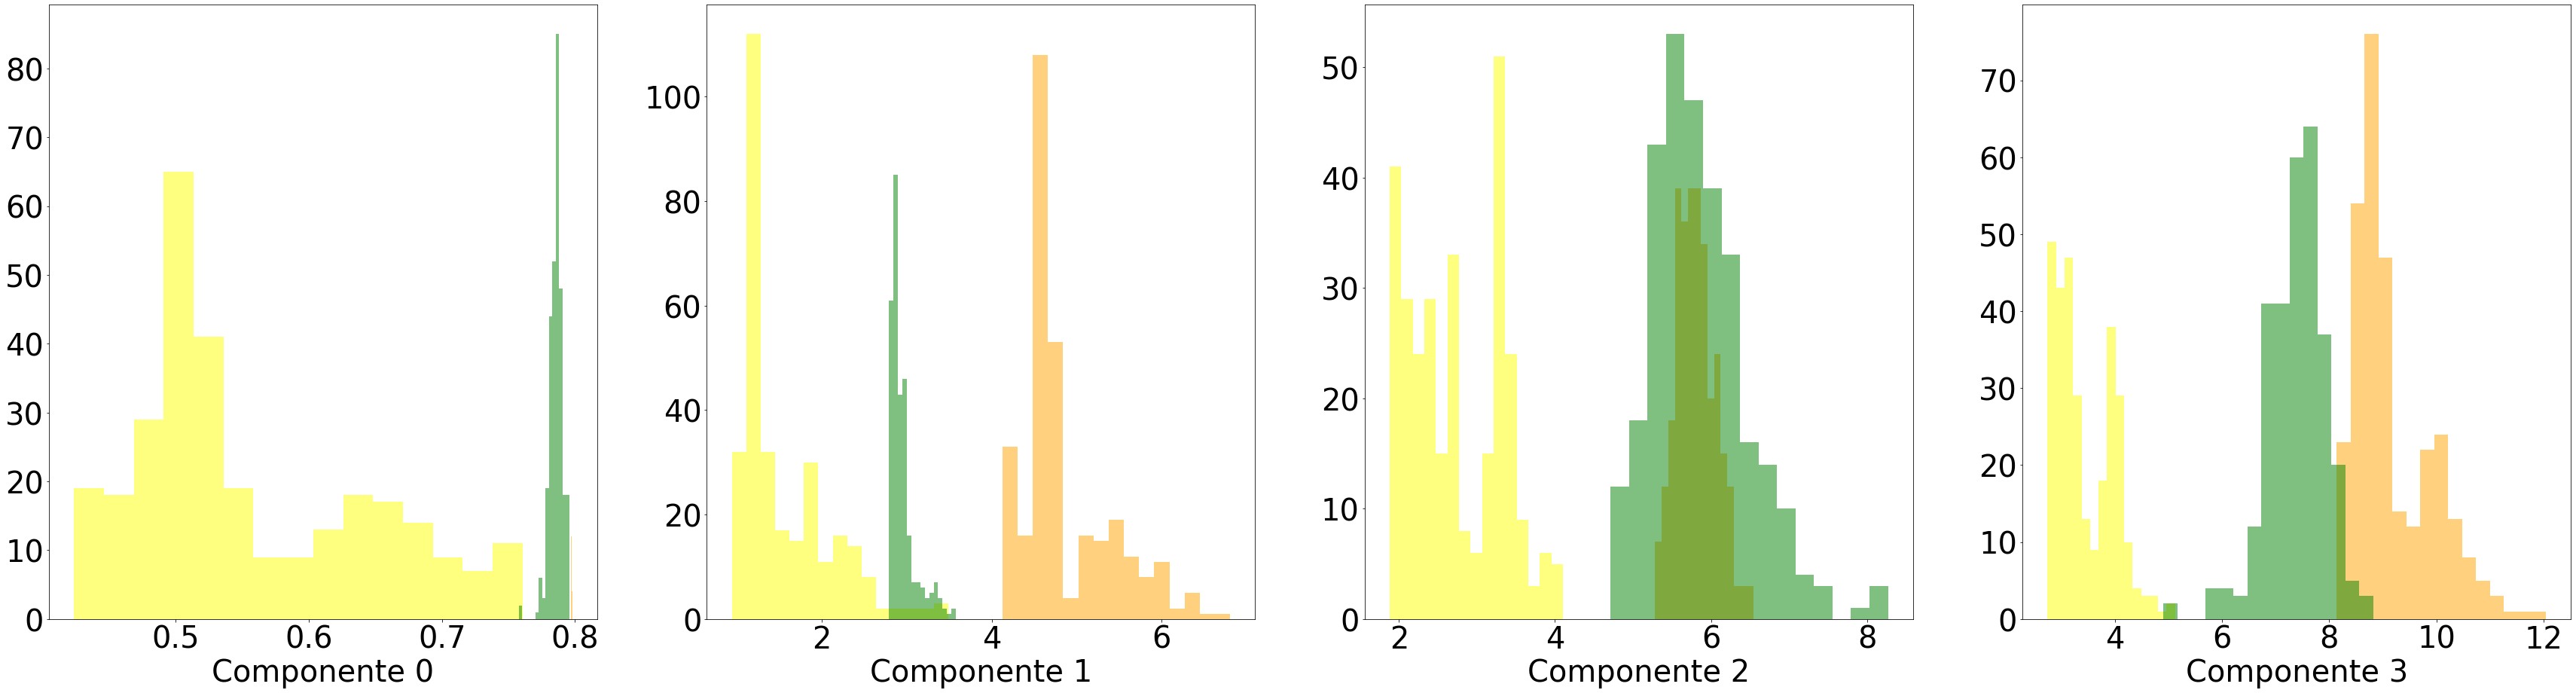

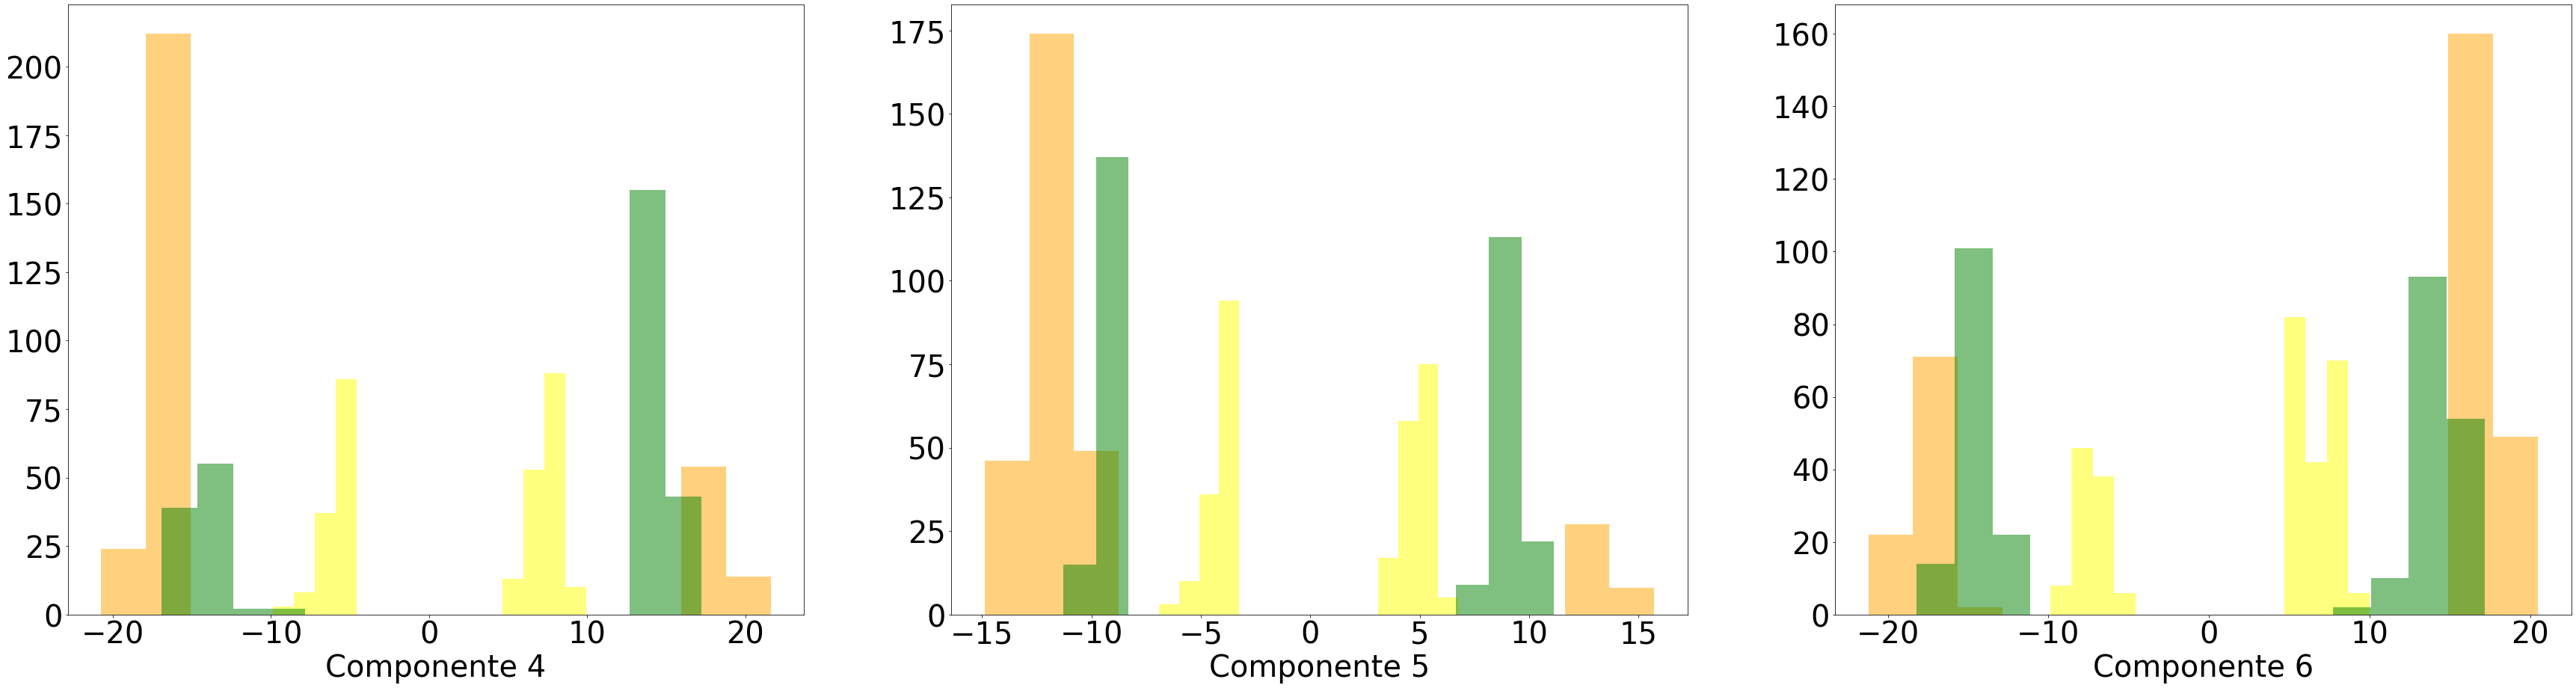

In [555]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 40})


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(60, 15))

n = 0
for i in range(0, 4):

    ax[i].hist(banana_hu_moments[:, i], bins=15, color='yellow', alpha=0.5)
    ax[i].hist(orange_hu_moments[:, i], bins=15, color='orange', alpha=0.5)
    ax[i].hist(lemon_hu_moments[:, i], bins=15, color='green', alpha=0.5)
    
    ax[i].set_xlabel("Componente {}".format(n))
    n += 1
    

    #ax[1, i].hist(banana_hu_moments[:, i], bins='auto', color='green', cumulative='True')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(60, 15))

k = 0
for i in range(4, 7):

    ax[k].hist(banana_hu_moments[:, i], bins=15, color='yellow', alpha=0.5)
    ax[k].hist(orange_hu_moments[:, i], bins=15, color='orange', alpha=0.5)
    ax[k].hist(lemon_hu_moments[:, i], bins=15, color='green', alpha=0.5)
    ax[k].set_xlabel("Componente {}".format(n))
    
    n += 1
    k += 1

plt.show()



Banana mean:  7.434044523130846
Std. dev:  4.979362600395841 

Orange mean:  1.0557661966776641
Std. dev:  0.02570548970128938 

Lemon mean:  1.5275417987478148
Std. dev:  0.09065204871059523 



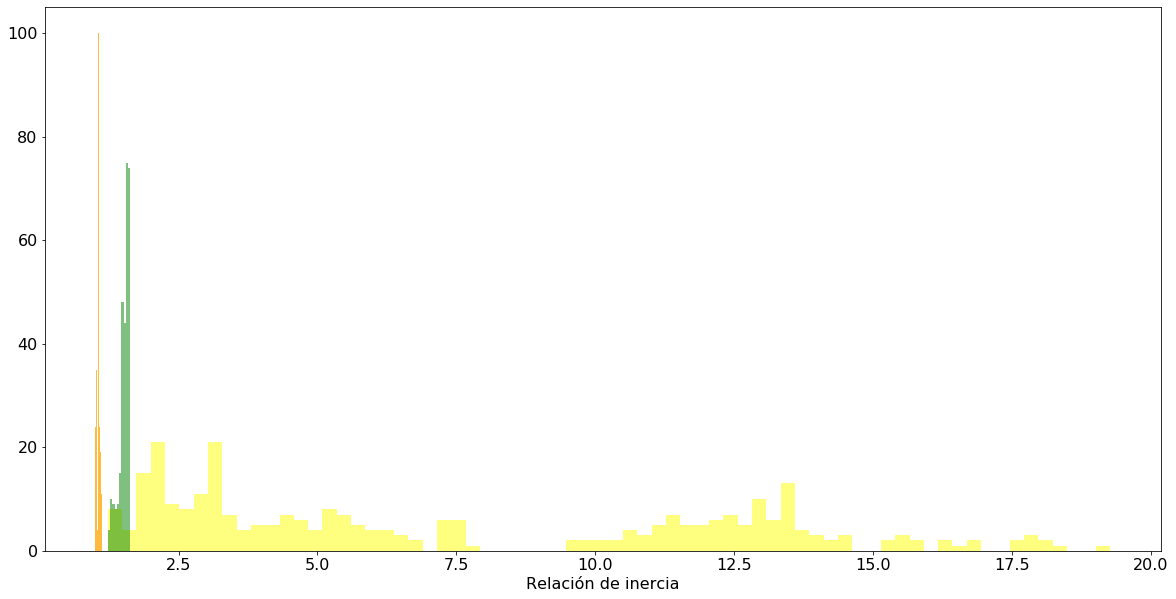

In [522]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

bins = np.arange(0, 20, 0.05)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

ax.hist(banana_moment_ratio, bins=70, color='yellow', alpha=.5)
ax.hist(orange_moment_ratio, bins=10, color='orange', alpha=.75)
ax.hist(lemon_moment_ratio, bins=10, color='green', alpha=.5)

ax.set_xlabel("Relación de inercia")

#ax[0].hist(banana_moment_ratio, bins=70, color='yellow', alpha=.5)
#ax[0].hist(orange_moment_ratio, bins=10, color='orange', alpha=.5)
#ax[0].hist(lemon_moment_ratio, bins=10, color='green', alpha=.5)

#ax[1].hist(banana_moment_ratio, bins=50, color='yellow', alpha=.5, cumulative=True)
#ax[1].hist(orange_moment_ratio, bins='auto', color='orange', alpha=.5, cumulative=True)
#ax[1].hist(lemon_moment_ratio, bins='auto', color='green', alpha=.5, cumulative=True)

print("Banana mean: ", np.mean(banana_moment_ratio))
print("Std. dev: ", np.std(banana_moment_ratio), "\n")

print("Orange mean: ", np.mean(orange_moment_ratio))
print("Std. dev: ", np.std(orange_moment_ratio), "\n")

print("Lemon mean: ", np.mean(lemon_moment_ratio))
print("Std. dev: ", np.std(lemon_moment_ratio), "\n")

(0, 671.639142350184)

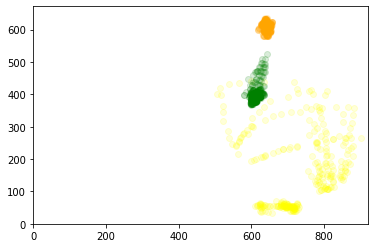

In [486]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.scatter(x=banana_eigvalues[:, 0], y=banana_eigvalues[:, 1], c='yellow', alpha=.15)
ax.scatter(x=orange_eigvalues[:, 0], y=orange_eigvalues[:, 1], c='orange', alpha=.15)
ax.scatter(x=lemon_eigvalues[:, 0], y=lemon_eigvalues[:, 1], c='green', alpha=.15)

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)


(0, 20.201652797300973)

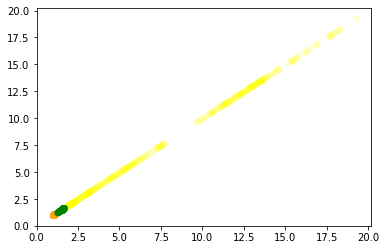

In [487]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.scatter(x=banana_moment_ratio[:], y=banana_moment_ratio[:], c='yellow', alpha=.15)
ax.scatter(x=orange_moment_ratio[:], y=orange_moment_ratio[:], c='orange', alpha=.15)
ax.scatter(x=lemon_moment_ratio[:], y=lemon_moment_ratio[:], c='green', alpha=.15)

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)


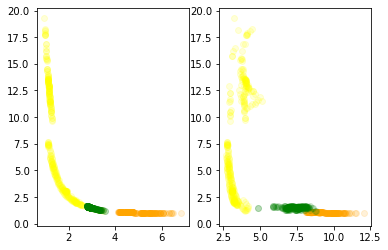

In [488]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].scatter(y=banana_moment_ratio[:], x=banana_hu_moments[:, 1], c='yellow', alpha=.15)

ax[0].scatter(y=orange_moment_ratio[:], x=orange_hu_moments[:, 1], c='orange', alpha=.15)

ax[0].scatter(y=lemon_moment_ratio[:], x=lemon_hu_moments[:, 1], c='green', alpha=.15)


ax[1].scatter(y=banana_moment_ratio[:], x=banana_hu_moments[:, 3], c='yellow', alpha=.15)

ax[1].scatter(y=orange_moment_ratio[:], x=orange_hu_moments[:, 3], c='orange', alpha=.15)

ax[1].scatter(y=lemon_moment_ratio[:], x=lemon_hu_moments[:, 3], c='green', alpha=.15)

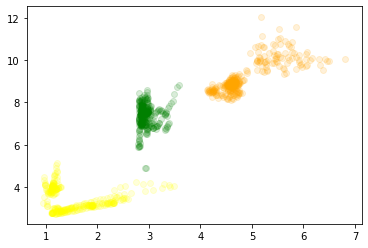

In [489]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.scatter(y=banana_hu_moments[:, 3], x=banana_hu_moments[:, 1], c='yellow', alpha=.15)

ax.scatter(y=orange_hu_moments[:, 3], x=orange_hu_moments[:, 1], c='orange', alpha=.15)

ax.scatter(y=lemon_hu_moments[:, 3], x=lemon_hu_moments[:, 1], c='green', alpha=.15)

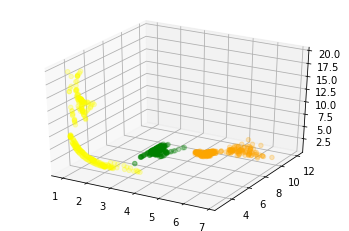

In [490]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(banana_hu_moments[:, 1], banana_hu_moments[:, 3], banana_moment_ratio[:], c='yellow', alpha=.25)
ax.scatter(orange_hu_moments[:, 1], orange_hu_moments[:, 3], orange_moment_ratio[:], c='orange', alpha=.25)
ax.scatter(lemon_hu_moments[:, 1], lemon_hu_moments[:, 3], lemon_moment_ratio[:], c='green', alpha=.25)

plt.show()